In [1]:
import mlflow


from utils.dataImportation import *
from utils.evaluation import *
from utils.performance_tables import *
from utils.staticModels import SplitDeepFactorNNList

/Users/sebastienlegros/Developer/DIVFM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
path_to_database = '../data'
STOCK = 'AAPL'
MODEL_RUN_ID = '0eb20054cba64168bedf9eacfb8e6d46'
USE_MLFLOW = True

In [3]:
model: SplitDeepFactorNNList = mlflow.pytorch.load_model(f"runs:/{MODEL_RUN_ID}/model")
assert isinstance(model, SplitDeepFactorNNList), f"Loaded model is {type(model)}"

In [4]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 39,364


In [5]:
FEATURES_NAME = ['ttm', 'ttm_scaled_moneyness'] if STOCK == 'SPX' else ['ttm', 'ttm_scaled_moneyness', 'time_to_earnings']
USE_LOG_VOL = True
BEGIN_TRAIN_DATE = '2010-01-01'  # '2000-01-01'
END_TRAIN_DATE = '2011-01-01'  # '2021-01-01'
BEGIN_TEST_DATE = '2011-06-01' # '2022-01-01'

client = mlflow.MlflowClient()
client = mlflow.tracking.MlflowClient()
run_id = MODEL_RUN_ID

In [6]:
labels_name = ['LOG_OM_IV'] if USE_LOG_VOL else ['OM_IV']
model_output_fn = torch.exp if USE_LOG_VOL else torch.nn.Identity()


In [7]:
options_data = import_data(path_to_database, STOCK)
earning_dates = import_earnings_date(path_to_database, STOCK)
options_data = merge_options_earnings(options_data, earning_dates)
options_data = apply_filters_to_options(options_data)
if STOCK != 'SPX': options_data = generate_tte(options_data, earning_dates)

train_data, valid_data, test_data = split_in_sets(options_data.dropna(), BEGIN_TRAIN_DATE, END_TRAIN_DATE, BEGIN_TEST_DATE)
train_dataset, valid_dataset, test_dataset = get_datasets(train_data, valid_data, test_data,
                                                          FEATURES_NAME, labels_name, dtype=torch.float32)

In [8]:
VIX_data = merge_vix_data(f'{path_to_database}/VIX.csv', f'{path_to_database}/VIXApple.csv')
full_data, daily_data = create_full_and_daily_datasets(model, train_dataset, valid_dataset,test_dataset, earning_dates, VIX_data)
if STOCK != 'SPX': daily_data = generate_tte(daily_data, earning_dates)

/Users/sebastienlegros/Developer/DIVFM/utils/evaluation.py:119: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_metrics = full_data.groupby('date').apply(compute_daily_RMSE_and_ARPE)


In [9]:
# daily_data = daily_data.loc[(daily_data['date'] != '2012-12-03') * (daily_data['date'] != '2012-12-04') * (daily_data['date'] != '2005-08-17') * (daily_data['date'] != '2012-12-05') * (daily_data['date'] != '2003-04-10') * (daily_data['date'] != '2003-04-07') * (daily_data['date'] != '2003-03-27') * (daily_data['date'] != '2003-04-17'), :]

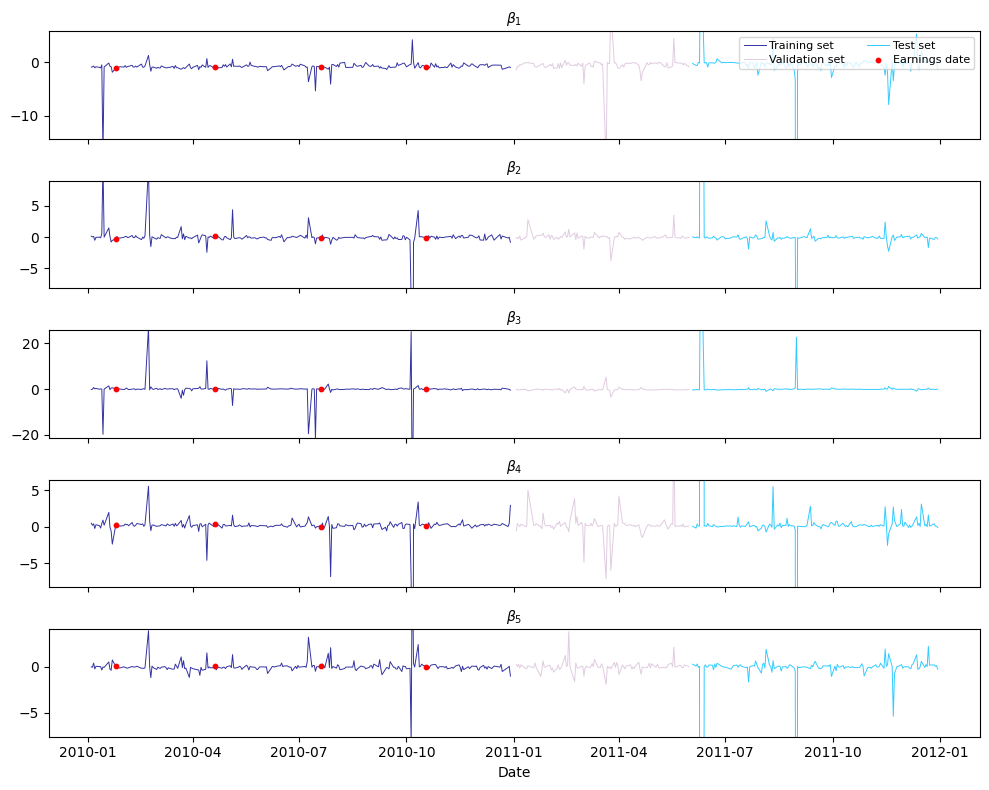

In [10]:
fig = plot_betas_timeseries(daily_data, alpha=0.005, n_std=1)
client.log_figure(run_id=run_id, figure=fig, artifact_file='betas_timeseries/betas_earnings_all_dates.png')
plt.show()

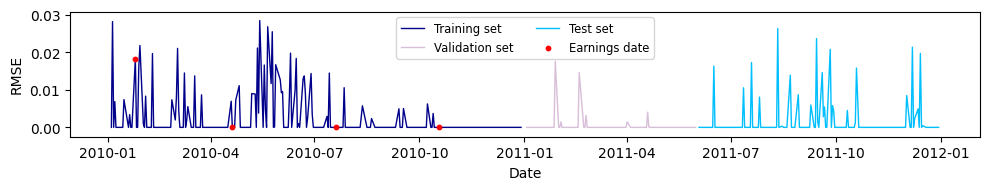

In [11]:
fig = plot_rmse_timeseries(daily_data, date_col='date', alpha=0.001, n_std=0.5)
client.log_figure(run_id=run_id, figure=fig, artifact_file='performance_timeseries/RMSE_timeseries.png')
plt.show()

In [12]:
static_arbitrage_pred = static_arbitrage_by_date(full_data, price_col='price_pred')
static_arbitrage_OM = static_arbitrage_by_date(full_data, price_col='OM_price_pred')
agg_static_arbitrage_pred = aggregate_by_date(static_arbitrage_pred)
agg_static_arbitrage_OM = aggregate_by_date(static_arbitrage_OM)


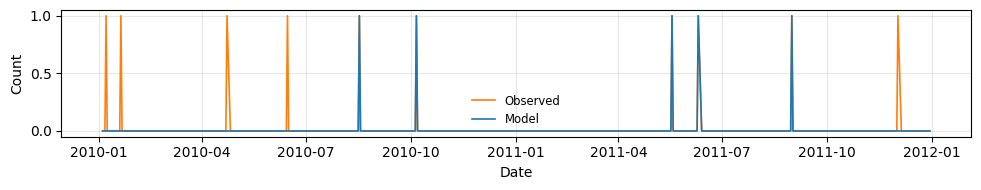

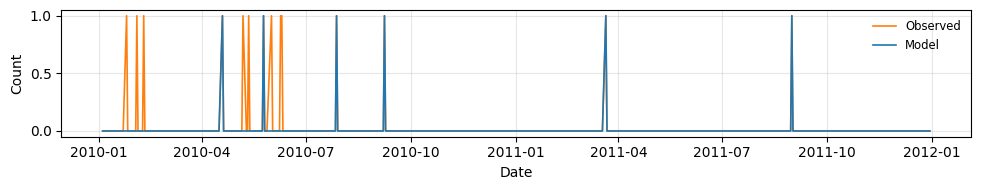

In [13]:
# Counts only
figs = plot_arb_aggregates(
    agg_static_arbitrage_pred,
    agg_static_arbitrage_OM,
    value_cols=["sum_call_spreads_pos", "sum_butterflies_pos"],
    labels=("Model", "Observed"),
    ylabels=("Count", "Count"),
    figsize=(10, 2),
    # colors=("darkblue", "red")
)


client.log_figure(run_id=run_id, figure=figs[0], artifact_file="arb/daily_countsCS.png")
client.log_figure(run_id=run_id, figure=figs[1], artifact_file="arb/daily_countsBS.png")

plt.show()

In [14]:
agg_static_arbitrage_pred.sum_butterflies_pos.sum() / agg_static_arbitrage_pred.total_weight.sum(), agg_static_arbitrage_OM.sum_butterflies_pos.sum() / agg_static_arbitrage_OM.total_weight.sum()

(np.float64(0.0032537960954446853), np.float64(0.007592190889370932))

In [15]:
df_sum = pd.DataFrame(agg_static_arbitrage_pred.drop(columns=['date']).sum())
df_sum = df_sum.reset_index().rename(columns={'index': 'metric', 0: 'count'})
mlflow.log_table(run_id=run_id, data=df_sum, artifact_file="arb/arb_table.json")

In [16]:
dates = select_window_dates(daily_data, '2022-01-27', window_below=2, window_above=1, use_earnings=False)

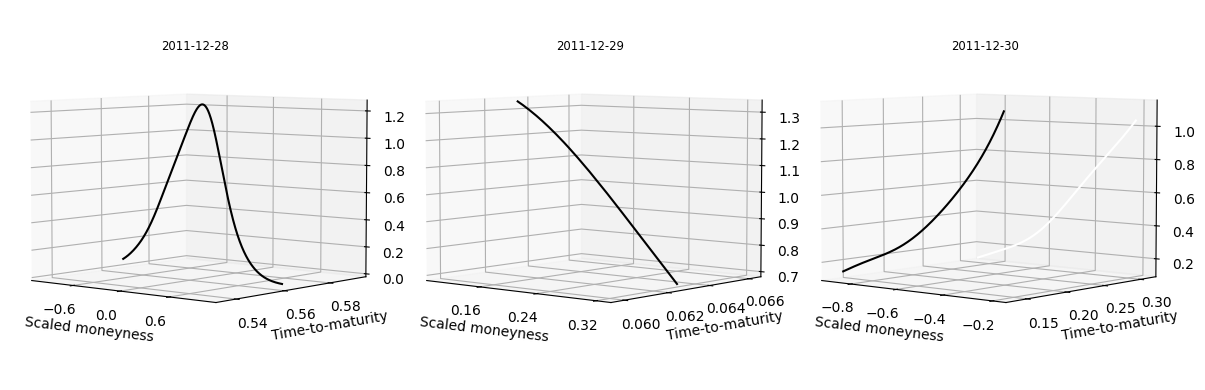

In [17]:
fig = plot_rnd_surfaces_by_date(dates, model, full_data, daily_data, thin_every=2, scaled_moneyness_range=None)
client.log_figure(run_id=run_id, figure=fig, artifact_file='surfaces/risk_neutral_density_moneyness.png')
plt.show()

In [18]:
vix30_df = compute_vix_timeseries(full_data, daily_data, model, TAU=30)
daily_data = pd.merge(daily_data, vix30_df, on='date', how='left')

Computing VIX30:   0%|          | 0/483 [00:00<?, ?it/s]/Users/sebastienlegros/Developer/DIVFM/utils/evaluation.py:1775: RuntimeWarning: invalid value encountered in divide
  density /= area
Computing VIX30:   4%|▍         | 20/483 [00:00<00:01, 281.58it/s]


RuntimeError: step must be nonzero

In [ ]:
stock_vix_col = f"{STOCK}VIX" if STOCK != 'SPX' else None
fig = plot_vix_timeseries(daily_data, stock_vix_col=stock_vix_col)
client.log_figure(run_id=run_id, figure=fig, artifact_file=f'performance_timeseries/VIX30.png')
plt.show()

In [19]:
full_data = add_tau_moneyness_bins(full_data)

In [20]:
LABEL1 = "RMSE - DIVFM with TTEA"
LABEL2 = None
M_LABELS_ORDER = tuple(f"M{i+1}" for i in range(10))
M_LABELS_ORDER_MATH = tuple(rf"$\text{{M}}_{{{i+1}}}$" for i in range(10)) + ('All',)
TAU_LABELS_ORDER = tuple(f"tau{i+1}" for i in range(10))
TAU_LABELS_ORDER_MATH = tuple(rf"$\tau_{{{i+1}}}$" for i in range(10)) + ("All",)

In [21]:
m_summary = summarize_by_moneyness_or_tau_full(full_data,
                                        bin_col = "moneyness_bin",
                                        moneyness_or_tau_col = "ttm_scaled_moneyness",
                                        labels_order=M_LABELS_ORDER,
                                        pred_col1 = "IVpred",
                                        pred_col2 = None,
                                        label1 = LABEL1,
                                        label2 = LABEL2, 
                                        )
tau_summary = summarize_by_moneyness_or_tau_full(full_data,
                                        bin_col = "tau_bin",
                                        moneyness_or_tau_col = "days_to_maturity",
                                        labels_order=TAU_LABELS_ORDER,
                                        pred_col1 = "IVpred",
                                        pred_col2 = None,
                                        label1 = LABEL1,
                                        label2 = LABEL2, 
                                        )

moneyness_str = bins_table_to_latex(m_summary, label1=LABEL1, label2=LABEL2, bin_headers_math=M_LABELS_ORDER_MATH)
tau_str = bins_table_to_latex(tau_summary, label1=LABEL1, label2=LABEL2, bin_headers_math=TAU_LABELS_ORDER_MATH)


client.log_table(run_id=run_id, data=summary_to_long_df(m_summary), artifact_file=f"performance_tables/moneyness_table.json")
client.log_table(run_id=run_id, data=summary_to_long_df(tau_summary), artifact_file=f"performance_tables/ttm_table.json")
client.log_text(run_id=run_id, text=moneyness_str, artifact_file="performance_tables/moneyness_latex_table.txt")
client.log_text(run_id=run_id, text=tau_str, artifact_file="performance_tables/ttm_latex_table.txt")

/Users/sebastienlegros/Developer/DIVFM/utils/performance_tables.py:110: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily = s.groupby(date_col, sort=True).apply(_rmse_for_date)
/Users/sebastienlegros/Developer/DIVFM/utils/performance_tables.py:110: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily = s.groupby(date_col, sort=True).apply(_rmse_for_date)
/Users/sebastienlegros/Developer/DIVFM/utils/performance_table

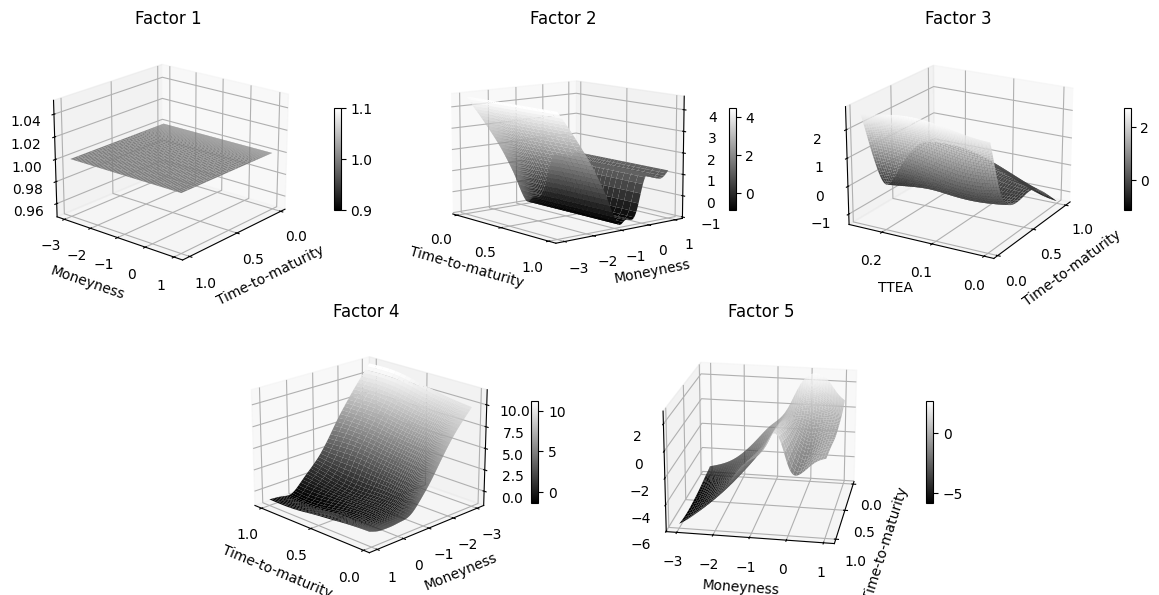

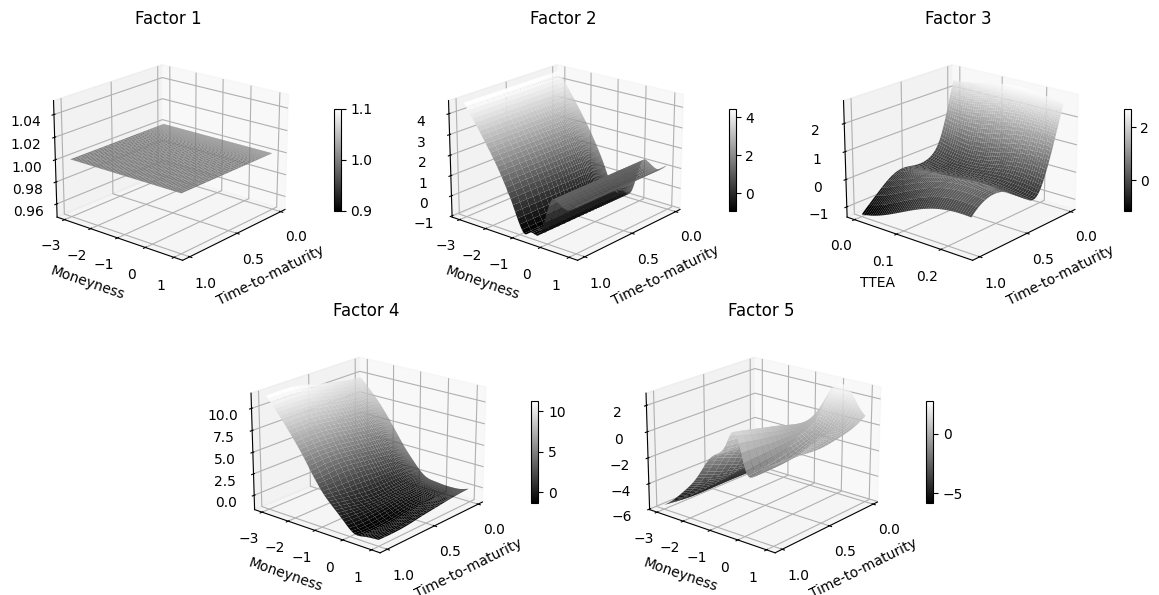

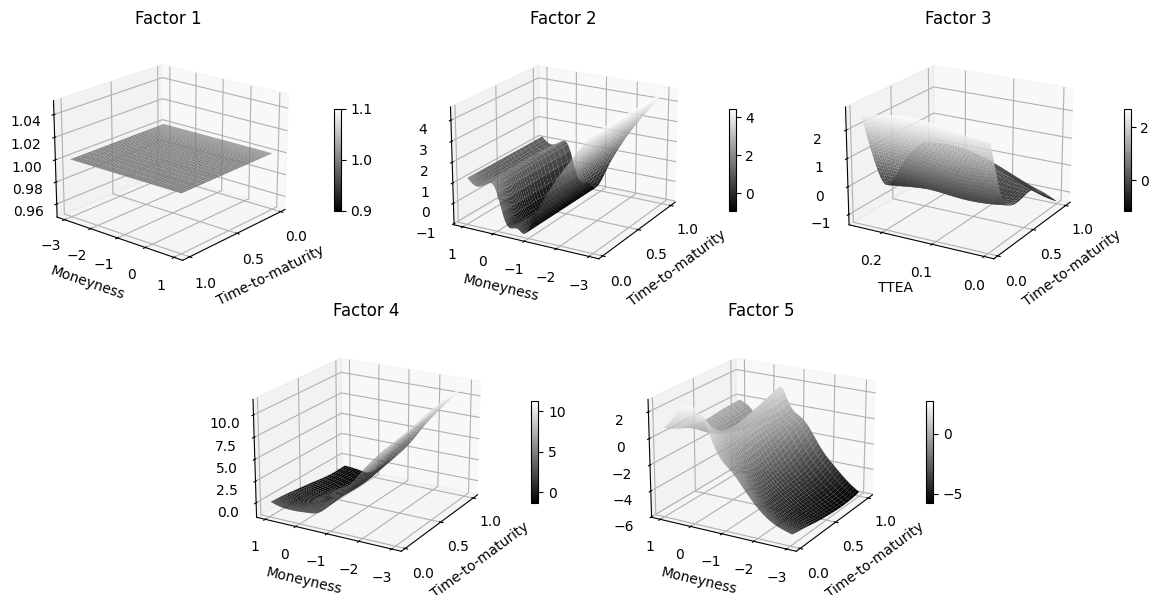

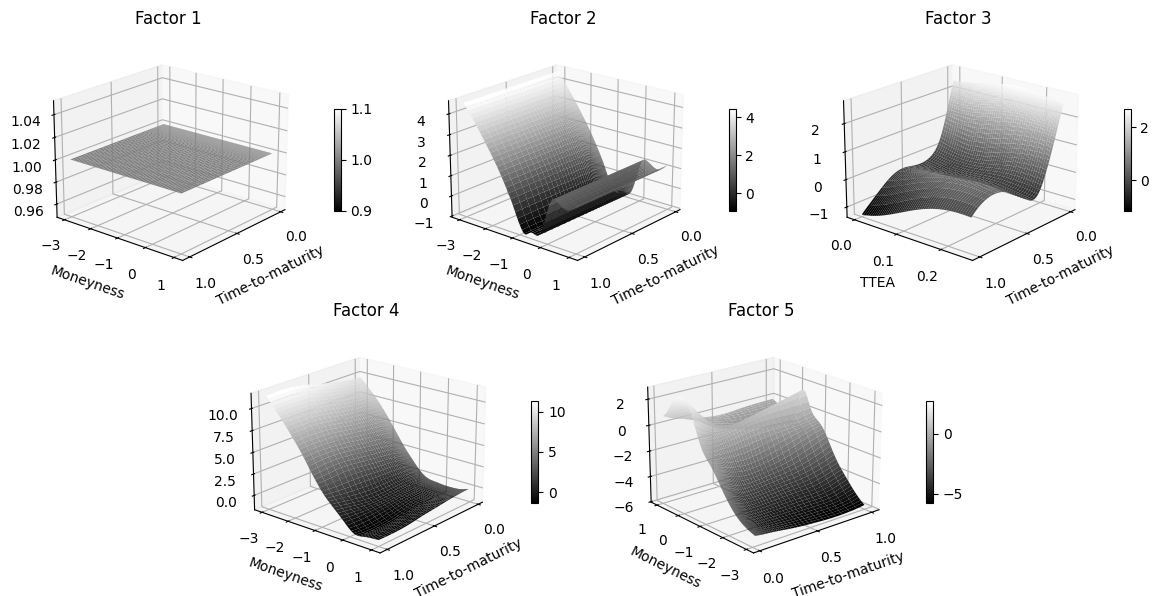

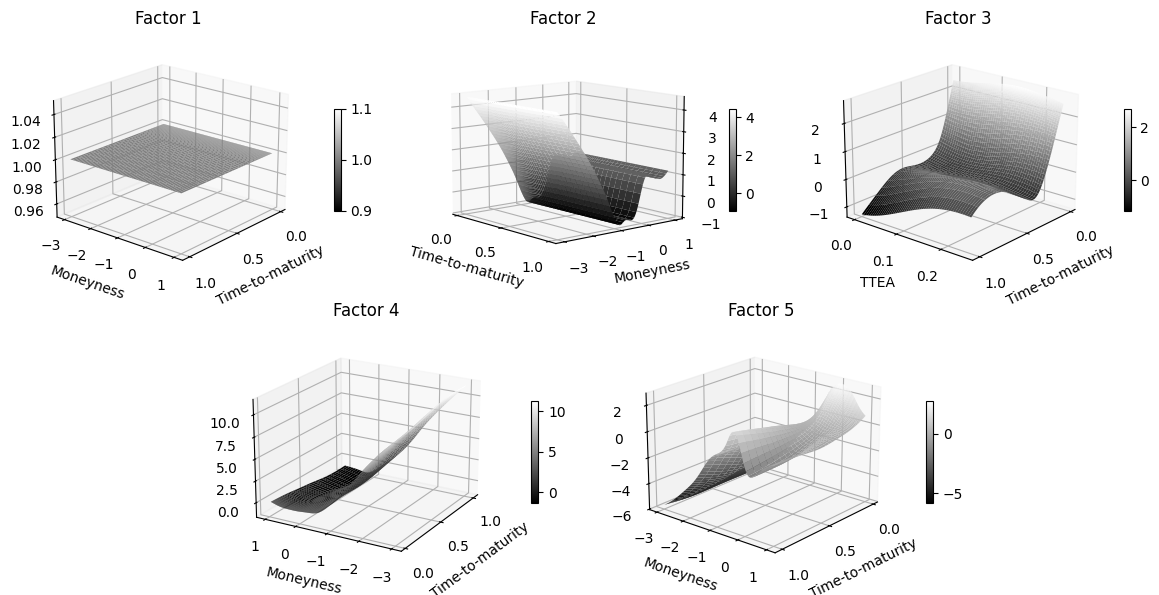

In [22]:
VIEW_ANGLES_LIST = [[(20, 40), (10, 320), (20, 210), (20, 135), (20, 10)],
                    [(20, 40), (20, 40), (20, 40), (20, 40), (20, 40)],
                    [(20, 40), (20, 210), (20, 210), (20, 210), (20, 210)],
                    [(20, 40), (20, 40), (20, 40), (20, 40), (20, 230)],
                    [(20, 40), (10, 320), (20, 40), (20, 210), (20, 40)]]

figs = render_factor_surfaces(model, VIEW_ANGLES_LIST)
for i, fig in enumerate(figs):
    client.log_figure(run_id=run_id, figure=fig, artifact_file=f'surfaces/factors{i}.png')
plt.show()